# Profiting from classifiers
### Mini-project
In this project you apply your classification skills for solving a business problem.

Imagine that you are working for a bank. Last year the bank sent a mass direct mailing offer to promote the Personal Equity Plan (PEP). You collected the information about customers and their responses into the dataset [bank_data.csv](https://drive.google.com/file/d/13VEWvirEi-AQwQzZwVZxDSKwym0vAvIk/view?usp=sharing). 

You want to make use of these data to design a new mailing campaign with a higher response rate. The ultimate goal is to spend less for the campaign, but increase the overall profit (number of respondents).

The idea is to build a classification model from historical data, and use this classifier on new customers to predict who is more likely to respond. We can then selectively target only these customers, and not waste the effort on unpromising customer groups.

## Part 1. Building a model

### 1.1. Data exploration and preparation

In [73]:
file_name = "../proj_ml_bank/bank-data.csv"

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# this creates a pandas.DataFrame using the id column for indexing
data = pd.read_csv(file_name, index_col ='id')

In [75]:
data.columns

Index(['age', 'sex', 'region', 'income', 'married', 'children', 'car',
       'save_act', 'current_act', 'mortgage', 'pep'],
      dtype='object')

In [76]:
data.head()

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
id,,,,,,,,,,,
ID12101,48,FEMALE,INNER_CITY,17546.0,NO,1,NO,NO,NO,NO,YES
ID12102,40,MALE,TOWN,30085.1,YES,3,YES,NO,YES,YES,NO
ID12103,51,FEMALE,INNER_CITY,16575.4,YES,0,YES,YES,YES,NO,NO
ID12104,23,FEMALE,TOWN,20375.4,YES,3,NO,NO,YES,NO,NO
ID12105,57,FEMALE,RURAL,50576.3,YES,0,NO,YES,NO,NO,NO


The dataset contains the following variables/attributes for each potential customer: 
- id (String)
- age (int)
- sex {FEMALE,MALE}
- region {INNER_CITY,TOWN,RURAL,SUBURBAN}
- income (int)
- married {YES, NO}
- children (int)
- car {YES, NO}
- save_act - Saving account in our bank {Yes, No}
- current_act - Current account in our bank {YES, NO}
- mortgage {YES, NO}

And the last attribute - pep {YES, NO} is a target attribute: whether a customer responded to our promotion mail and joined a Personal Equity Plan.

To see correlation between attributes and response, we convert all attributes to numeric: .

In [77]:
# First, create a copy of the original data frame - to make a fully numeric dataset

df_num = data.copy()

# we need to replace 'sex', 'region', 'married', 'car', 'save_act', 'current_act', 'mortgage', 'pep'

The boolean values can be replaced with [0,1].

In [78]:
print(df_num['sex'].unique())
print(df_num['married'].unique())
print(df_num['car'].unique())
print(df_num['save_act'].unique())
print(df_num['current_act'].unique())
print(df_num['mortgage'].unique())
print(df_num['pep'].unique())

['FEMALE' 'MALE']
['NO' 'YES']
['NO' 'YES']
['NO' 'YES']
['NO' 'YES']
['NO' 'YES']
['YES' 'NO']


In [79]:
df_num['sex'].replace(['FEMALE', 'MALE'], [0,1], inplace=True)

df_num['married'].replace(['NO', 'YES'], [0,1], inplace=True)
df_num['car'].replace(['NO', 'YES'], [0,1], inplace=True)
df_num['save_act'].replace(['NO', 'YES'], [0,1], inplace=True)
df_num['current_act'].replace(['NO', 'YES'], [0,1], inplace=True)
df_num['mortgage'].replace(['NO', 'YES'], [0,1], inplace=True)
df_num['pep'].replace(['NO', 'YES'], [0,1], inplace=True)

In [80]:
print(df_num['region'].unique())
print(df_num['children'].unique())

['INNER_CITY' 'TOWN' 'RURAL' 'SUBURBAN']
[1 3 0 2]


The 'region' attribute with cardinality 4 should be replaced using [one hot encoding](https://datagy.io/sklearn-one-hot-encode/). Please refresh your knowledge about converting categorical attributes into numerics (binary).

In [81]:
# One-hot encoding a single column - region - using pandas
# use pd.concat to join the new columns with your original dataframe
df_num = pd.concat([df_num,pd.get_dummies(df_num['region'], prefix='region')],axis=1)

# now drop the original 'region' column (you don't need it anymore)
df_num.drop(['region'],axis=1, inplace=True)

For the attribute 'children' there are only 4 distinct values - it is not a truly numeric attribute, it is rather an ordinal attribute. It also does not seem reasonable to assume that the difference between childless families and the families with 1 child is the same as the difference between 1-child and 2-child families. So we should probably treat the number of children as a categorical attribute with cardinality 4.  

In [82]:
df_num['children'].replace([0,1,2,3], ["zero","one", "two", "three"], inplace=True)

In [83]:
df_num = pd.concat([df_num,pd.get_dummies(df_num['children'], prefix='children')],axis=1)

# now drop the original 'country' column (you don't need it anymore)
df_num.drop(['children'],axis=1, inplace=True)

Reordering to place the target variable into the first column.

In [84]:
target = df_num.pop("pep")

df_num.insert(0, target.name, target)

In [85]:
df_num.columns

Index(['pep', 'age', 'sex', 'income', 'married', 'car', 'save_act',
       'current_act', 'mortgage', 'region_INNER_CITY', 'region_RURAL',
       'region_SUBURBAN', 'region_TOWN', 'children_one', 'children_three',
       'children_two', 'children_zero'],
      dtype='object')

<AxesSubplot:>

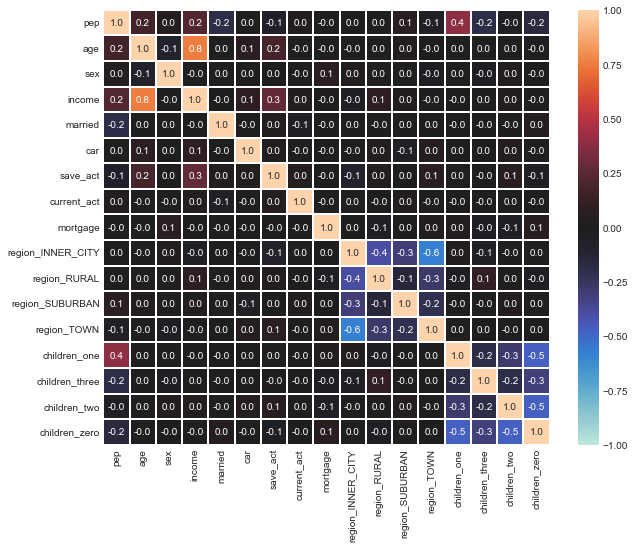

In [86]:
fig, ax = plt.subplots(figsize=(10,8)) 
corr = df_num.corr()
sns.heatmap(corr, center=0, annot=True, linewidths=.1, ax=ax, vmin=-1, vmax=1, fmt='.1f')

## 1.2. Classifiers
We learned about the following classifiers: 
- __Logistic Regression__
- __Support Vector Machines__
- __Decision Trees__
- __k-Nearest Neighbors__
- __Naive Bayes__

We explore each classifier in turn, trying to build the model with the best accuracy for the test set.
We compare classifiers using 10-20 fold cross validation. Do not forget to normalize numeric attributes. After each experiment, use statistical comparison to find out if the current classifier is better than the previous one.

__The best score that I managed to achieve was 89.7. So you should not settle for anything less than 89.5.__

Document all your experiments in the cells below.

### Classifiers that work only with numeric attributes

### K-NN
Use all your knowledge from the K-NN lab to build the K-NN classifier with the best prediction rate. 

In [87]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [88]:
num_cols = ['age', 'income']
X = df_num[num_cols]
y = df_num['pep']
kf = KFold(n_splits=10, random_state=123, shuffle=True)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [89]:
knn = KNeighborsClassifier(weights='distance')
grid_dictionary = {'n_neighbors': np.arange(10,40)}

#use gridsearch to test all values for n_neighbors
grid = GridSearchCV(knn, grid_dictionary, cv=kf)

#fit model to data
grid.fit(X_scaled, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=KNeighborsClassifier(weights='distance'),
             param_grid={'n_neighbors': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])})

In [90]:
grid.best_estimator_

KNeighborsClassifier(n_neighbors=36, weights='distance')

In [91]:
acc = cross_val_score(grid.best_estimator_, X_scaled, y, cv=kf).mean()
print(f'KNN Accuracy: {acc:.2f}')

KNN Accuracy: 0.61


### Logistic Regression
Try Logistic Regression. Try different Expectation Maximization algorithms. Maybe some variations of regularization? 

Is your Log Regr score better than the K-NN score? Is it significantly better? If the scores do not differ significantly, you may continue with any of them. Otherwise, continue with the better classifier.

In [92]:
lr = LogisticRegression()
acc = cross_val_score(lr, X_scaled, y, cv=kf).mean()
print(f'LogisticRegression Accuracy: {acc:.2f}')

LogisticRegression Accuracy: 0.59


In [93]:
lr = LogisticRegression(C=0.01)
acc = cross_val_score(lr, X_scaled, y, cv=kf).mean()
print(f'LogisticRegression Accuracy: {acc:.2f}')

LogisticRegression Accuracy: 0.58


### Support Vector Machines
Try to improve classification with SVM. Compare the scores statistically. COntinue with a better classifier.

In [94]:
svm = SVC(kernel='linear')
acc = cross_val_score(svm, X_scaled, y, cv=kf).mean()
print(f'SVM Accuracy: {acc:.2f}')

SVM Accuracy: 0.58


### Classifiers that work with both numeric and categorical attributes
### Naive Bayes
We can use Naive Bayes classifier on the original dataset without replacing categorical values with numeric ones. 
Think which parameters still need to be adjusted. Maybe try binning income and age into categorical bins. Try Naive Bayes classifier. Adjust parameters. Maybe you can use a ROC curve to set a different classification threshold? Select the best classifer so far.

In [95]:
X = df_num.drop(columns='pep')
y = df_num['pep']
kf = KFold(n_splits=10, random_state=123, shuffle=True)

sc = StandardScaler()
X_scaled = X.copy()
X_scaled[:] = sc.fit_transform(X)

In [96]:
gb = GaussianNB()
acc = cross_val_score(gb, X_scaled, y, cv=kf).mean()
print(f'GaussianNB Accuracy: {acc:.2f}')

GaussianNB Accuracy: 0.69


### Decision tree
Unfortunately the sklearn implementation of the decision tree does not take the full advantage of the decision tree power. The sklearn implementation does not work with categorical attributes. You can of course use it on the numeric dataset. The reesults however will be discouraging. Nevertheless try it, play with parameters.

You have of course the option of using our custom Decision tree code. You can look at the decision tree produced by our custom code to determine which attributes are most important for classification. You can then reweight them, or even get rid of some attributes and repeat your experiments with all the five classifiers. As a matter of fact, using only a subset of attributes identified this way I was able to improve the classification score.

You can also use our custom decision tree as a final classifier, but it requires additional coding to produce probability of class prediction and to evaluate the performance. So do it only if you have time (and desire).

In [97]:
dt = DecisionTreeClassifier(max_depth=6)
acc = cross_val_score(dt, X_scaled, y, cv=kf).mean()
print(f'DecisionTreeClassifier Accuracy: {acc:.2f}')

DecisionTreeClassifier Accuracy: 0.86


### SELECT FINAL CLASSIFIER
After all the experiments, select the classifier with the best accuracy (you used cross-validation).

Now break your dataset into two parts (using 1:2 ratio) and use one part for testing and 2 parts for building the model.

After you buid the final model, make the predictions for each instance in the test set, and record these predictions as _PROBABILITIES_ of belonging to the 'pep' class. __Store these predictions in a separate csv file. This is the input for Part II of this mini-project.__

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=123, shuffle=True, test_size=.33)

In [99]:
dt = DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)
y_prob = dt.predict_proba(X_test)[:,1]
X_final = X_test.copy()
X_final['prob'] = y_prob
X_final['pep'] = y_test
X_final.to_csv('y_prob.csv', index=False)

## Part II. Business pitch

### Lift chart
The result of the previous part is the table of predicted class labels for each instance in the test set. The predictions are expressed in terms of probability of being classified as 'pep' - that is, probability that the respondents buy the equity plan.

Our main business proposal is to take a new dataset of potential subscribers, predict their response using our best model, and use only top-ranked customers for the next promotion. 

Here we want to persuade the bank that targeting selected customers will improve the campaign efficiency: that we can achieve a much better response rate.

First, we sort the test dataset by the predicted class - from Yes to No, and then by probability (from highest to the lowest for Yes and from lowest to highest for No). Keep the sorted file separately from the original test set - we need both datasets.

Next, we count the number of successfully predicted subscribers, adding for each row in the sorted dataset the cumulative number of customers which responded to the offer. Now, for each number of letter sent we plot the total number of positive responses (see image below for an example). 

<img src = "images/counts.png" text-align="center" width=50%>

What can we learn from this chart? The logic is that if we send 10 letters - the success rate of these letters will be high, because 9 out of 10 would reply. If we send 100 letters the success rate would be 69%. However with 100 letters this means 69 new subscribers, and with 10 - only 9. We want to know what is the optimal number of letters to be sent to maximize the profit.

<img src = "images/LiftChart.png" text-align="center" width=50%>

For business audience we visualize the results using lift charts, where on the X axis is a number of letters sent, and on the Y axis is the proportion of positive responses for the random mailing and for the mailing which would use the top-ranked customers first. Lift (in the business world) is the ratio of the expected ‘Yes’ responses using the top of predicted list to the number of ‘Yes’ responses from the same number of randomly selected customers. Lift measures the change in the concentration of a target class when the model is applied to the future dataset. Note that if we would send all 180 letters we would have 83 positive responses (46% total success) in both cases.

Analyzing this chart, we can see that by sending mails to only 73/180 = 40% of the customers from the top of the ranked list, we should be able to cover 82% of potential responders. 

Note that we cannot ever cover all 100% of responsive customers, unless we send letters to everybody - our model does not give 100% correct answers.

In [100]:
data.shape

(600, 11)

__Create the Lift chart from your results, and write a couple of sentences pitching the use of a classifier.__

In [101]:
y_random = X_final[['pep', 'prob']].copy()
y_sorted = X_final[['pep', 'prob']].copy()
y_sorted = y_sorted.sort_values('prob', ascending=False)

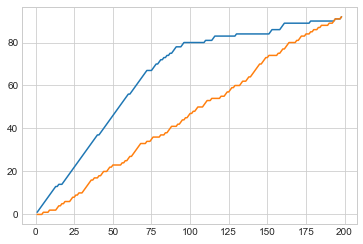

In [102]:
plt.plot(np.arange(1, y_prob.shape[0]+1), np.cumsum(y_sorted['pep']))
plt.plot(np.arange(1, y_prob.shape[0]+1), np.cumsum(y_random['pep']))


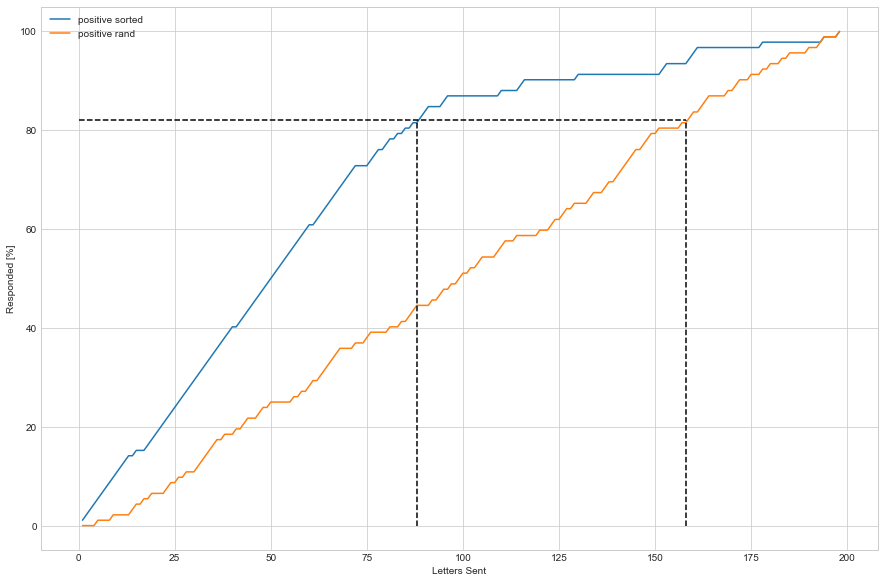

In [103]:
plt.figure(figsize=(15,10))
respond_sort = np.cumsum(y_sorted['pep'])/y_sorted['pep'].sum()*100
respond_rand = np.cumsum(y_random['pep'])/y_sorted['pep'].sum()*100
plt.plot(np.arange(1, y_prob.shape[0]+1), respond_sort, label='positive sorted')
plt.plot(np.arange(1, y_prob.shape[0]+1), respond_rand, label='positive rand')

i1 = np.where(respond_sort > 82)[0][0]
i2 = np.where(respond_rand > 82)[0][0]
plt.plot([0, i2], [82, 82], 'k--')
plt.plot([i1, i1], [0, 82], 'k--')
plt.plot([i2, i2], [0, 82], 'k--')
plt.xlabel('Letters Sent')
plt.ylabel('Responded [%]')
plt.grid(':')
plt.legend();

In [104]:
np.where(respond_sort > 82)[0][0]

88

With our decision tree classifier, we see that we achieved the same performance with only half of the number of letters that were sent.  

### Cost-benefit analysis

Just showing the lift chart might be not enough to persuade bank to apply your classifier. We need to estimate potential revenue.

How to choose the optimal number of letters to send? This depends on the:
- Cost of each mail: for example, let it be $4
- Benefit from each accepted PEP: let it be $15
These unrealistic numbers were chosen because of the very small size of the validation dataset – to demonstrate the concept of maximum profit. In real life, the cost of mailing is several cents, and the benefit is hundreds and thousands dollars, but the real datasets of mailings contain millions of records.

Then for each row in the sorted table:
- We multiply each count of total sent by 4 - the cost of sending
- We multiply each positive count by 15 - expected benefit (not everything that we predicted as positive was actually positive, some of our predictions were wrong).
- We subtract the cost from the benefit. 
This produces an expected revenue for a given number of letters sent.

In my results sending about 71-73 letters gave the maximum profit of ~ 700 dollars. This profit cannot be achieved by random mailing, this is the profit to our company that we created using machine learning. BTW, what would be the total profit if we sent just 73 letters from the random dataset?

__What are your results? Did you manage to generate more profit?__ Briefly discuss your results and what did you learn from this project.


## Results

95


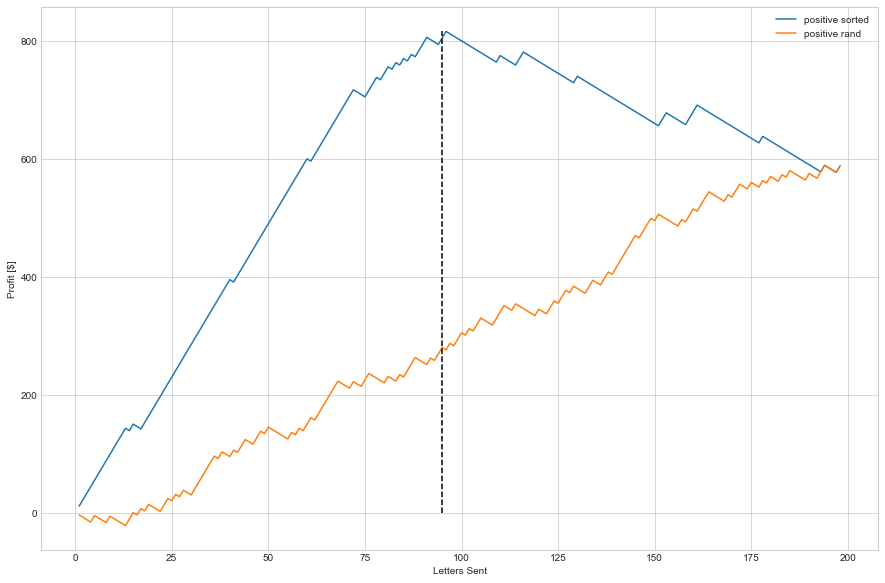

In [105]:
plt.figure(figsize=(15,10))
profit_sort = np.cumsum(y_sorted['pep']*15) - np.arange(1, y_prob.shape[0]+1)*4
profit_rand = np.cumsum(y_random['pep']*15) - np.arange(1, y_prob.shape[0]+1)*4
plt.plot(np.arange(1, y_prob.shape[0]+1), profit_sort, label='positive sorted')
plt.plot(np.arange(1, y_prob.shape[0]+1), profit_rand, label='positive rand')

i1 = np.argmax(profit_sort)
print(i1)
plt.plot([i1, i1], [0, profit_sort[i1]], 'k--')
plt.xlabel('Letters Sent')
plt.ylabel('Profit [$]')
plt.grid(':')
plt.legend();

For this analysis, after all the experiments, the classifier with the best accuracy was the Decision Tree type. The model approached an accuracy of 86%. The data we see in the chart shows that we have a profit of about 800 dollars if we have a total of 95 positive sorted letters which consists of 47% of the entire group of clients. Randomly, at the same number of letters, we can only profit with less than 300 dollars. Thus, this classifies has the optimum performance among other classifiers. 

95


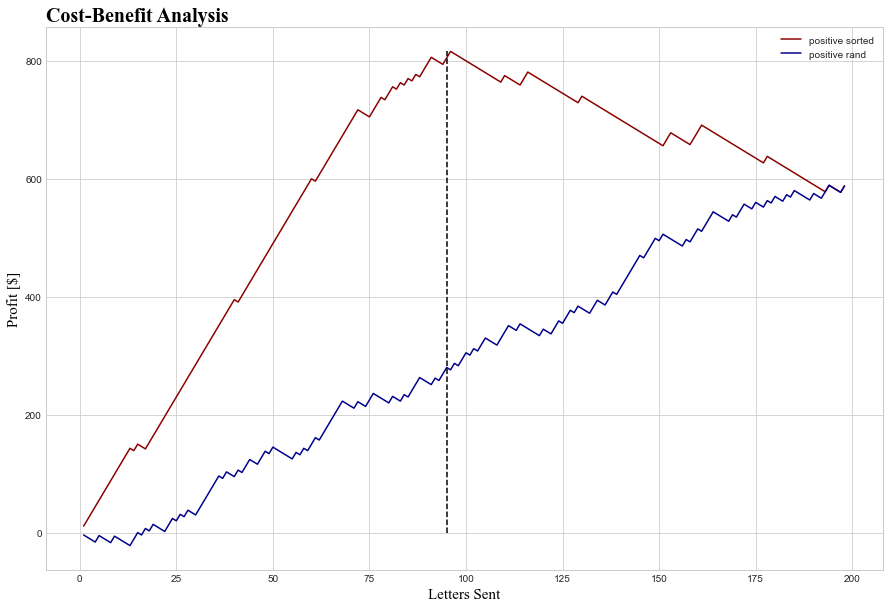

In [106]:
plt.figure(figsize=(15,10))

profit_sort = np.cumsum(y_sorted['pep']*15) - np.arange(1, y_prob.shape[0]+1)*4
profit_rand = np.cumsum(y_random['pep']*15) - np.arange(1, y_prob.shape[0]+1)*4
plt.plot(np.arange(1, y_prob.shape[0]+1), profit_sort, label='positive sorted', color = 'darkred')
plt.plot(np.arange(1, y_prob.shape[0]+1), profit_rand, label='positive rand', color ='darkblue')

i1 = np.argmax(profit_sort)
print(i1)
plt.plot([i1, i1], [0, profit_sort[i1]], 'k--')
plt.style.use('seaborn-whitegrid')
plt.title('Cost-Benefit Analysis', size = 20, loc = 'left', family = "Times New Roman", color = "black", weight='bold')
plt.xlabel('Letters Sent',size = 15, family = "Times New Roman", color = "black")
plt.ylabel('Profit [$]',size = 15, family = "Times New Roman", color = "black")
plt.grid(':')
plt.legend()
plt.show()

In [107]:
profit_sort.shape

(198,)


This project was very interesting to do, and it showed me how to apply machine learning models to market strategies. I will definitely be doing more projects in this area. 

Copyright &copy; 2022 Marina Barsky. All rights reserved.